# Identify the MJO phase by OLR and wind data

Madden-Julian Oscillation [(MJO)](ftp://128.171.154.9/pub/rlukas/LSASI/MJO/MJOrev_Zhang.pdf) is the dominant component of the intraseasonal (30–90 days) variability in the tropical atmosphere. It consists of large-scale coupled patterns in atmospheric circulation and deep convection, propagating eastward slowly at a speed of 5m/s. through the portion of the Indian and Pacific oceans where the sea surface is warm. It constantly interacts with the underlying ocean and influences many weather and climate systems. 

The MJO phase diagram illustrates the progression of the MJO through different phases (1-8), which generally coincide with locations along the equator around the globe. RMM1 and RMM2 are mathematical methods that combine cloud amount and winds at upper and lower levels of the atmosphere to provide a measure of the strength and location of the MJO. When the index is within the centre circle the MJO is considered weak, meaning it is difficult to discern using the RMM methods. Outside of this circle the index is stronger and will usually move in an anti-clockwise direction as the MJO moves from west to east. The latest phase diagram can be found [here.](http://www.bom.gov.au/climate/mjo/graphics/rmm.phase.Last40days.gif)


__MJO phase plot__
<img src="http://www.bom.gov.au/climate/mjo/graphics/rmm.phase.Last40days.gif" width="400">


The Real-time Multivariate MJO series 1 (RMM1) and 2 (RMM2) are based on a pair of empirical orthogonal functions (EOFs) of the combined fields of near-equatorially averaged 850-hPa zonal wind, 200-hPa zonal wind, and satellite-observed outgoing longwave radiation (OLR) data. Projection of the daily observed data onto the multiple-variable EOFs, with the annual cycle and components of interannual variability removed, yields principal component (PC) time series that vary mostly on the intraseasonal time scale of the MJO only [Wheeler and Hendon, 2004.](https://journals.ametsoc.org/doi/abs/10.1175/1520-0493%282004%29132%3C1917%3AAARMMI%3E2.0.CO%3B2)

__Variation of rainfall at tropics for different MJO phases__
<img src="https://www.pnas.org/content/pnas/107/45/19171/F1.large.jpg?width=800&height=600&carousel=1" width="800">

Applications of the RMM series are investigated. One application is through their relationship with the onset dates of the monsoons in Australia and India; while the onsets can occur at any time during the convectively enhanced half of the MJO cycle, they rarely occur during the suppressed half. Another application is the modulation of the probability of extreme weekly rainfall; in the “Top End” region around Darwin, Australia, the swings in probability represent more than a tripling in the likelihood of an upper-quintile weekly rainfall event from the dry to wet MJO phase.

The idea here is to get these indices through the machine learning techniques without using any filtering and empirical orthogonal functions (EOFs) methods. So I will input the raw images and try to predict the MJO phases. I know it would be a difficult job since even after the filtering the first two principal components (PC) explain only about 40% of the variance. Moreover the method could also misclassify the border cases as belonging to either of the  neighbouring phases.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import keras
import xarray
plt.ion()

Using TensorFlow backend.


Since MJO is a tropical phenomena only data between 30 deg North to 30 deg South is used as input. Outgoing longwave radiaiton (OLR) and zonal (east - west) winds at two different pressure levels, 200hPa and 850hPa are used and is available [here.](https://www.esrl.noaa.gov/psd/data/gridded/)
MJO indices can be obtained [here.](http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt)
Data from the years 1979 to 2017 (39 years) is used. 

Since successive day's data are somewhat correlated the test, train and validation splits are performed (60:20:20 ratio) from different years and then randomly shuffled among the individual subsets.


In [2]:
def extractData(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out = data[var]
    sel={}
    sel['lat'] = slice(30,-30)
    out = out.loc[sel]
    tm  = data.time.dt.year   
    out = out[(tm >= yearMin) & (tm <= yearMax)]
    out = (out.values).reshape(out.shape[0],-1)
    out = (out - np.mean(out))/np.std(out)
    return out 

def extractPLData(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out = data[var]
    sel={}
    sel['lat'] = slice(30,-30)
    out = out.loc[sel]
    tm  = data.time.dt.year   
    out = out[(tm >= yearMin) & (tm <= yearMax)]
    out = out[:,0,:,:].values
    out = out.reshape(out.shape[0],-1)
    out = (out - np.mean(out))/np.std(out)
    return out 

In [3]:
olr  = extractData('Data/olr.day.mean.nc', 'olr', 1979, 2017)
u200 = extractPLData('Data/u200.nc', 'uwnd', 1979, 2017)
u850 = extractPLData('Data/u850.nc', 'uwnd', 1979, 2017)

In [4]:
dataIdx = pd.read_csv('Data/rmmData.txt', skiprows=[0,1],sep='\s+',header=None)
dataIdx.drop(dataIdx.columns[[-1,]], axis=1, inplace=True)
dataIdx.columns = ['Year', 'Month', 'Date', 'RMM1', 'RMM2', 'Phase', 'Amplitude']
dataIdx = dataIdx[(dataIdx.Year >= 1979) & (dataIdx.Year <=2017)]
phase = dataIdx.Phase.values
amplitude = dataIdx.Amplitude.values

### Random Forest

Let's first use Random Forests to classify the phases.
To begin with only Outgoing Lonwave Radiation (OLR) data is used as an input.

In [5]:
X = olr
Y = phase
np.random.seed(23)

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_val   = X[valIdx]
Y_val   = Y[valIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_val  shape:", X_val.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (8547, 3600)
X_val  shape: (2849, 3600)
X_test shape: (2849, 3600)


Accuracy: 0.3345033345033345


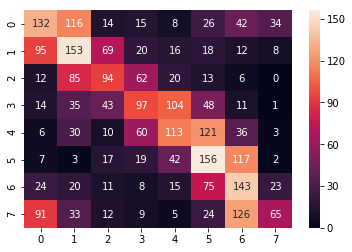

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rnd_clf = RandomForestClassifier(n_estimators=1000,  n_jobs=-1, random_state=23)
rnd_clf.fit(X_train, Y_train)
rnd_pred = rnd_clf.predict(X_val)

print('Accuracy:', accuracy_score(Y_val, rnd_pred))
cmat =  confusion_matrix(Y_val, rnd_pred)
seaborn.heatmap(cmat, annot=True,fmt='g')

It has an accuracy of about 33%. Confusion matrix indicates that the model is confusing between the neighbouring phases as expected.

Now will include zonal wind (u) at 200 and 850 hPa levels along with OLR data.

In [7]:
X = np.hstack((olr,u200,u850))
Y = phase
np.random.seed(23)

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_val   = X[valIdx]
Y_val   = Y[valIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_val  shape:", X_val.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (8547, 10800)
X_val  shape: (2849, 10800)
X_test shape: (2849, 10800)


Accuracy: 0.4464724464724465


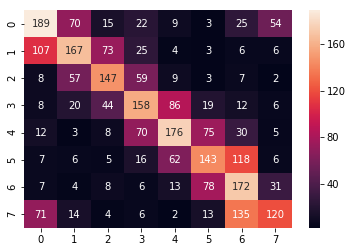

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rnd_clf = RandomForestClassifier(n_estimators=1000,  n_jobs=-1, random_state=23)
rnd_clf.fit(X_train, Y_train)
rnd_pred = rnd_clf.predict(X_val)

print('Accuracy:', accuracy_score(Y_val, rnd_pred))
cmat =  confusion_matrix(Y_val, rnd_pred)
seaborn.heatmap(cmat, annot=True,fmt='g')

Much better accuracy than the previous case. The accuracy has increased by about 10%.

### Neural Networks

Let's start with a simple dense connected network with one layer and progress from there by increasing the complexity. Softmax function is used to output the probabilities.

In [9]:
def extractDataNN(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out = data[var]
    sel={}
    sel['lat'] = slice(30,-30)
    out = out.loc[sel]
    tm  = data.time.dt.year   
    out = out[(tm >= yearMin) & (tm <= yearMax)]
    out = (out - np.mean(out))/np.std(out)
    return out 

def extractPLDataNN(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out = data[var]
    sel={}
    sel['lat'] = slice(30,-30)
    out = out.loc[sel]
    tm  = data.time.dt.year   
    out = out[(tm >= yearMin) & (tm <= yearMax)]
    out = out[:,0,:,:].values
    out = (out - np.mean(out))/np.std(out)
    return out 

In [10]:
olr  = extractDataNN('Data/olr.day.mean.nc', 'olr', 1979, 2017)
u200 = extractPLDataNN('Data/u200.nc', 'uwnd', 1979, 2017)
u850 = extractPLDataNN('Data/u850.nc', 'uwnd', 1979, 2017)

In [11]:
dataIdx = pd.read_csv('Data/rmmData.txt', skiprows=[0,1],sep='\s+',header=None)
dataIdx.drop(dataIdx.columns[[-1,]], axis=1, inplace=True)
dataIdx.columns = ['Year', 'Month', 'Date', 'RMM1', 'RMM2', 'Phase', 'Amplitude']
dataIdx = dataIdx[(dataIdx.Year >= 1979) & (dataIdx.Year <=2017)]
phase = dataIdx.Phase.values
amplitude = dataIdx.Amplitude.values

In [12]:
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
X = np.stack((olr,u200,u850),axis=3)
Y = to_categorical(phase-1)
assert len(X) == len(Y)

np.random.seed(23)

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_val   = X[valIdx]
Y_val   = Y[valIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_val  shape:", X_val.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (8547, 25, 144, 3)
X_val  shape: (2849, 25, 144, 3)
X_test shape: (2849, 25, 144, 3)


In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(X.shape[1],X.shape[2],X.shape[3])))
model.add(layers.Dense(8, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val,Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 86408     
Total params: 86,408
Trainable params: 86,408
Non-trainable params: 0
_________________________________________________________________
Train on 8547 samples, validate on 2849 samples
Epoch 1/10
8547/8547 [==============================] - 1s 64us/step - loss: 1.7268 - acc: 0.4433 - val_loss: 1.6249 - val_acc: 0.4728
Epoch 2/10
8547/8547 [==============================] - 0s 52us/step - loss: 1.0814 - acc: 0.6105 - val_loss: 2.0346 - val_acc: 0.4275
Epoch 3/10
8547/8547 [==============================] - 0s 51us/step - loss: 0.9830 - acc: 0.6546 - val_loss: 1.9782 - val_acc: 0.4345
Epoch 4/10
8547/8547 [==============================] - 0s 51us/step - loss: 0.71

(0, 9.45)

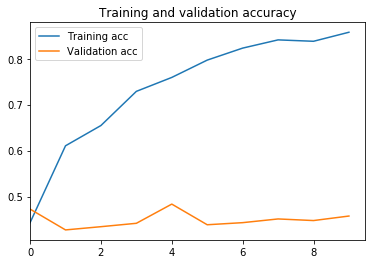

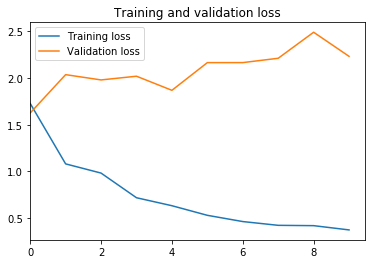

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(0,)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(0,)

In [15]:
loss, accuracy = model.evaluate(X_val, Y_val)
print ("Loss:", loss)
print ("Accuracy:", accuracy)

2849/2849 [==============================] - 0s 19us/step
Loss: 2.230117868157427
Accuracy: 0.4577044577044577


One layer neural network has similar accuracy to random forests. 
Training data is overfitting. So let's add even more layers with dropouts added for regularization.
I have done some coarse grid search and have shown here only the best case.
Please feel free to tune it even further.



In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(X.shape[1],X.shape[2],X.shape[3])))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_val,Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 10800)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1382528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
Total para

(0, 25.2)

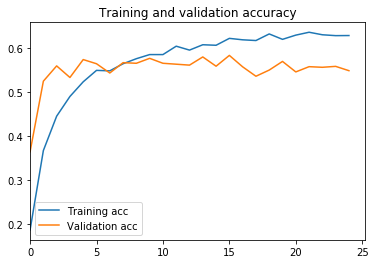

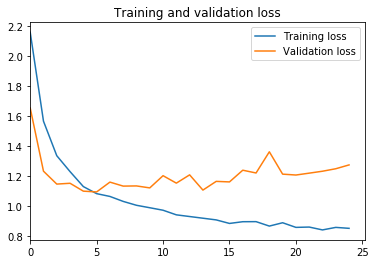

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(0,)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(0,)

In [18]:
loss, accuracy = model.evaluate(X_val, Y_val)
print ("Loss:", loss)
print ("Accuracy:", accuracy)

2849/2849 [==============================] - 0s 93us/step
Loss: 1.2759045789893697
Accuracy: 0.5493155493155493


Accuracy exceeds 50 % ! Further improvement of about 10 to 12 % accuracy is observed.

Now we'll use Convolutional Neural Networks (CNNs / ConvNets) above this dense network architecture and see whether the improves performance. Convnets are especially good in image recognition and might be helpful.
Maxpool layer is used after convnets.

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val,Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 144, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 36, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13824)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1769600   
__________

(0, 9.45)

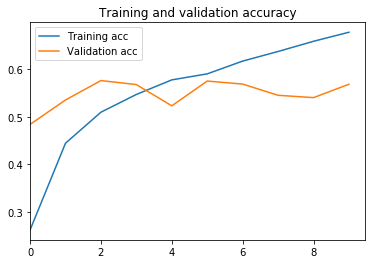

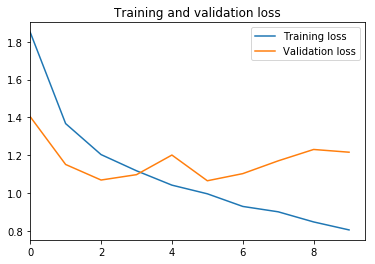

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(0,)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(0,)

In [21]:
loss, accuracy = model.evaluate(X_val, Y_val)
print ("Loss:", loss)
print ("Accuracy:", accuracy)

2849/2849 [==============================] - 2s 766us/step
Loss: 1.215532422588766
Accuracy: 0.5682695682695683


Convnets are performing slightly better than the dense networks (by about 2%). 
It could possibly because the local features learnt by convnets are not that transferable. For eg, it might identify the convection pattern along the tropics but for our problem the location of that region is the most important criterion to identify the phase. So the information learnt by convnets in one region is not easily transferble to identofy other regions.

Now let us train the model with all the data (*training + validation*) set. 
n_epochs is set to 6 as validation loss increases after that. 

In [32]:
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
X = np.stack((olr,u200,u850),axis=3)
Y = to_categorical(phase-1)
assert len(X) == len(Y)

np.random.seed(23)

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval
trainIdx = np.append(trainIdx,valIdx) # use both training and validation data

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (11396, 25, 144, 3)
X_test shape: (2849, 25, 144, 3)


In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=6, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 144, 32)       896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 72, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 36, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 13824)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1769600   
__________

In [34]:
loss, accuracy = model.evaluate(X_test, Y_test)
print ("Test Loss:", loss)
print ("Test Accuracy:", accuracy)

2849/2849 [==============================] - 2s 854us/step
Test Loss: 1.109124883303269
Test Accuracy: 0.5440505440505441


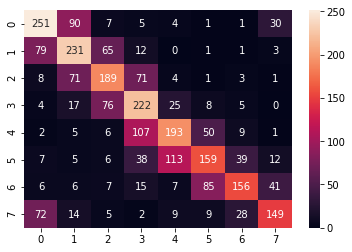

In [35]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
Y_pred1 = np.argmax(Y_pred, axis=1)
Y_test1 = np.argmax(Y_test, axis=1)
cmat =  confusion_matrix(Y_test1,Y_pred1)
seaborn.heatmap(cmat, annot=True,fmt='g')

Test accuracy is about 54.5 %. Confusion matrix indicates that the model is confusing between the neighbouring phases as expected. Due to this there may not be a good way to drastically improve this classification.

Still considering that we have not done any filtering of the inputs this seems to be a decent enough performance.
